<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Modules" data-toc-modified-id="Import-Modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Modules</a></span><ul class="toc-item"><li><span><a href="#General-Modules" data-toc-modified-id="General-Modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General Modules</a></span></li><li><span><a href="#Tensorflow" data-toc-modified-id="Tensorflow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tensorflow</a></span></li></ul></li><li><span><a href="#Initialization" data-toc-modified-id="Initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#VRAM-Steup" data-toc-modified-id="VRAM-Steup-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>VRAM Steup</a></span></li><li><span><a href="#Model-Parameters" data-toc-modified-id="Model-Parameters-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model Parameters</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Model-Class" data-toc-modified-id="Model-Class-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model Class</a></span></li><li><span><a href="#Build-Model" data-toc-modified-id="Build-Model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Build Model</a></span></li></ul></li><li><span><a href="#Load-Data-and-Calculation" data-toc-modified-id="Load-Data-and-Calculation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Data and Calculation</a></span></li><li><span><a href="#Varify" data-toc-modified-id="Varify-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Varify</a></span></li></ul></div>

## Import Modules

### General Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
import platform
import datetime
import pandas as pd
import pickle
import shutil
import importlib
import glob
import os

### Tensorflow

In [2]:
import tensorflow as tf
from keras.utils import io_utils, tf_utils
from tensorflow.keras import (layers, models,
                              utils, optimizers,
                              callbacks, regularizers,
                              losses, activations,
                              applications)
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision

## Initialization

### VRAM Steup

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Model Parameters

In [4]:
timestream_path = '.\\Segmented_timestream_data\\No_Activation\\'
output_path = '.\\Segmented_timestream_data\\No_Activation\\Interpolated\\'
weights_file = '.\\saved_LSTM_model_data\\selected_ConvLSTM_model\\best_model_weights.h5'
if not os.path.exists(output_path):
    os.mkdir(output_path)
    
#fold_num = 4
fold_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#######################
#   Model Parameters  #
#######################

block_num = 3
dropout_factor = 0.02
L2_factor = 1e-15
kernel_size = 3
filter_list = [24, 32, 48, 64, 96, 128]

## Model

### Model Class

In [5]:
class NextFramePrediction():
    def __init__(self,
                 block_num=6,
                 dropout_factor=0,
                 L2_factor=1e-15,
                 kernel_size=3,
                 filter_list=[64, 64, 64, 64, 64, 64],
                 ):
        self.block_num = block_num
        self.dropout_factor = dropout_factor
        self.L2_factor = L2_factor
        self.kernel_size = kernel_size
        self.filter_list = filter_list
        
        self.regularizer = regularizers.L2(L2_factor)
        
    def ConvLSTM_cell(self, input_layer, kernel_size, filters):
        l = layers.ConvLSTM2D(filters=filters,
                              kernel_size=(kernel_size, kernel_size),
                              padding='same',
                              kernel_regularizer=self.regularizer,
                              return_sequences=True,
                              dropout=self.dropout_factor)(input_layer)
        l = layers.BatchNormalization()(l)
        return l
    
    def ExpandDimension(self, input_layer, axis=1):
        shape = (-1,)
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        for i in range(1, input_dim):
            if not i == axis:
                shape += (input_shape[i],)
            else:
                shape += (1,)
                shape += (input_shape[i],)
        l = tf.reshape(input_layer, shape=shape)
        return l
    
    def DownWard_Block(self, input_layer, kernel_size, filters):
        c = self.ConvLSTM_cell(input_layer, kernel_size, filters)
        l = layers.TimeDistributed(layers.MaxPooling2D())(c)
        return c, l
    
    def UpWard_Block(self, input_layer, copied_layer, kernel_size, filters):      
        l = self.ConvLSTM_cell(input_layer, kernel_size, filters)
        l = layers.TimeDistributed(layers.UpSampling2D())(l)
        l = layers.Add()([l, copied_layer])
        return l
    
    def DownWardStream(self, input_layer):
        cs = []
        for i in range(self.block_num):
            if i == 0:
                filters = self.filter_list[i]
                c, l = self.DownWard_Block(input_layer,
                                           self.kernel_size,
                                           filters)
                cs.append(c)
            else:
                filters = self.filter_list[i]
                c, l = self.DownWard_Block(l,
                                           self.kernel_size,
                                           filters)
                cs.append(c)
        return cs, l
    
    def UpWardStream(self, l, cs):
        for i in range(self.block_num-1, -1, -1):
            filters = self.filter_list[i]
            l = self.UpWard_Block(l, cs[i],
                                  self.kernel_size,
                                  filters)
        return l
    
    def LSTM_Body(self, input_layer):
        cs, l = self.DownWardStream(input_layer)
        l = self.UpWardStream(l, cs)
        return l
    
    def Conv2D_Cell(self, input_layer, filters, activation):
        l = layers.Conv2D(filters=filters,
                          kernel_size=[3, 3],
                          activation=activation,
                          padding="same",
                          kernel_regularizer=self.regularizer)(input_layer)
        l = layers.BatchNormalization()(l)
        l = layers.Dropout(self.dropout_factor)(l)
        return l
    
    def Output_Stem(self, input_layer):
        l = layers.Conv3D(filters=int(np.sqrt(input_layer.shape[-1]*3)),
                          kernel_size=3,
                          activation="relu",
                          padding="same",
                          kernel_regularizer=self.regularizer)(input_layer)
        l = layers.BatchNormalization()(l)
        l = layers.Dropout(self.dropout_factor)(l)
        l = layers.Conv2D(filters=3,
                          kernel_size=1,
                          activation="sigmoid",
                          padding="same")(l)
        return l
    
    def Build_Model(self, input_shape):
        input_layer = layers.Input(input_shape)
        l_F = self.LSTM_Body(input_layer[:,0:4,...])
        l_B = self.LSTM_Body(input_layer[:,-1:-4:-1,...])
        l_middle = layers.Concatenate()([l_F[:,-1,...], l_B[:,-1,...]])
        l_middle = self.Conv2D_Cell(l_middle, 64, activation='relu')
        l_middle = self.Conv2D_Cell(l_middle, l_F.shape[-1], activation='relu')
        l = layers.Concatenate(axis=1)([l_F[:,0:-1,...], self.ExpandDimension(l_middle, axis=1),
                                        l_B[:,-2::-1,...]])
        l = self.Output_Stem(l)
        model = models.Model(input_layer, l)
        return model
    

### Build Model

In [6]:
model_mod = NextFramePrediction(block_num=block_num,
                                dropout_factor=dropout_factor,
                                L2_factor=L2_factor,
                                kernel_size=kernel_size,
                                filter_list=filter_list)
model = model_mod.Build_Model((8, 256, 256, 3))
model.load_weights(weights_file)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 256, 256  0           []                               
                                , 3)]                                                             
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 4, 256, 256,  0          ['input_1[0][0]']                
 ingOpLambda)                    3)                                                               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 3, 256, 256,  0          ['input_1[0][0]']                
 icingOpLambda)                  3)                                                           

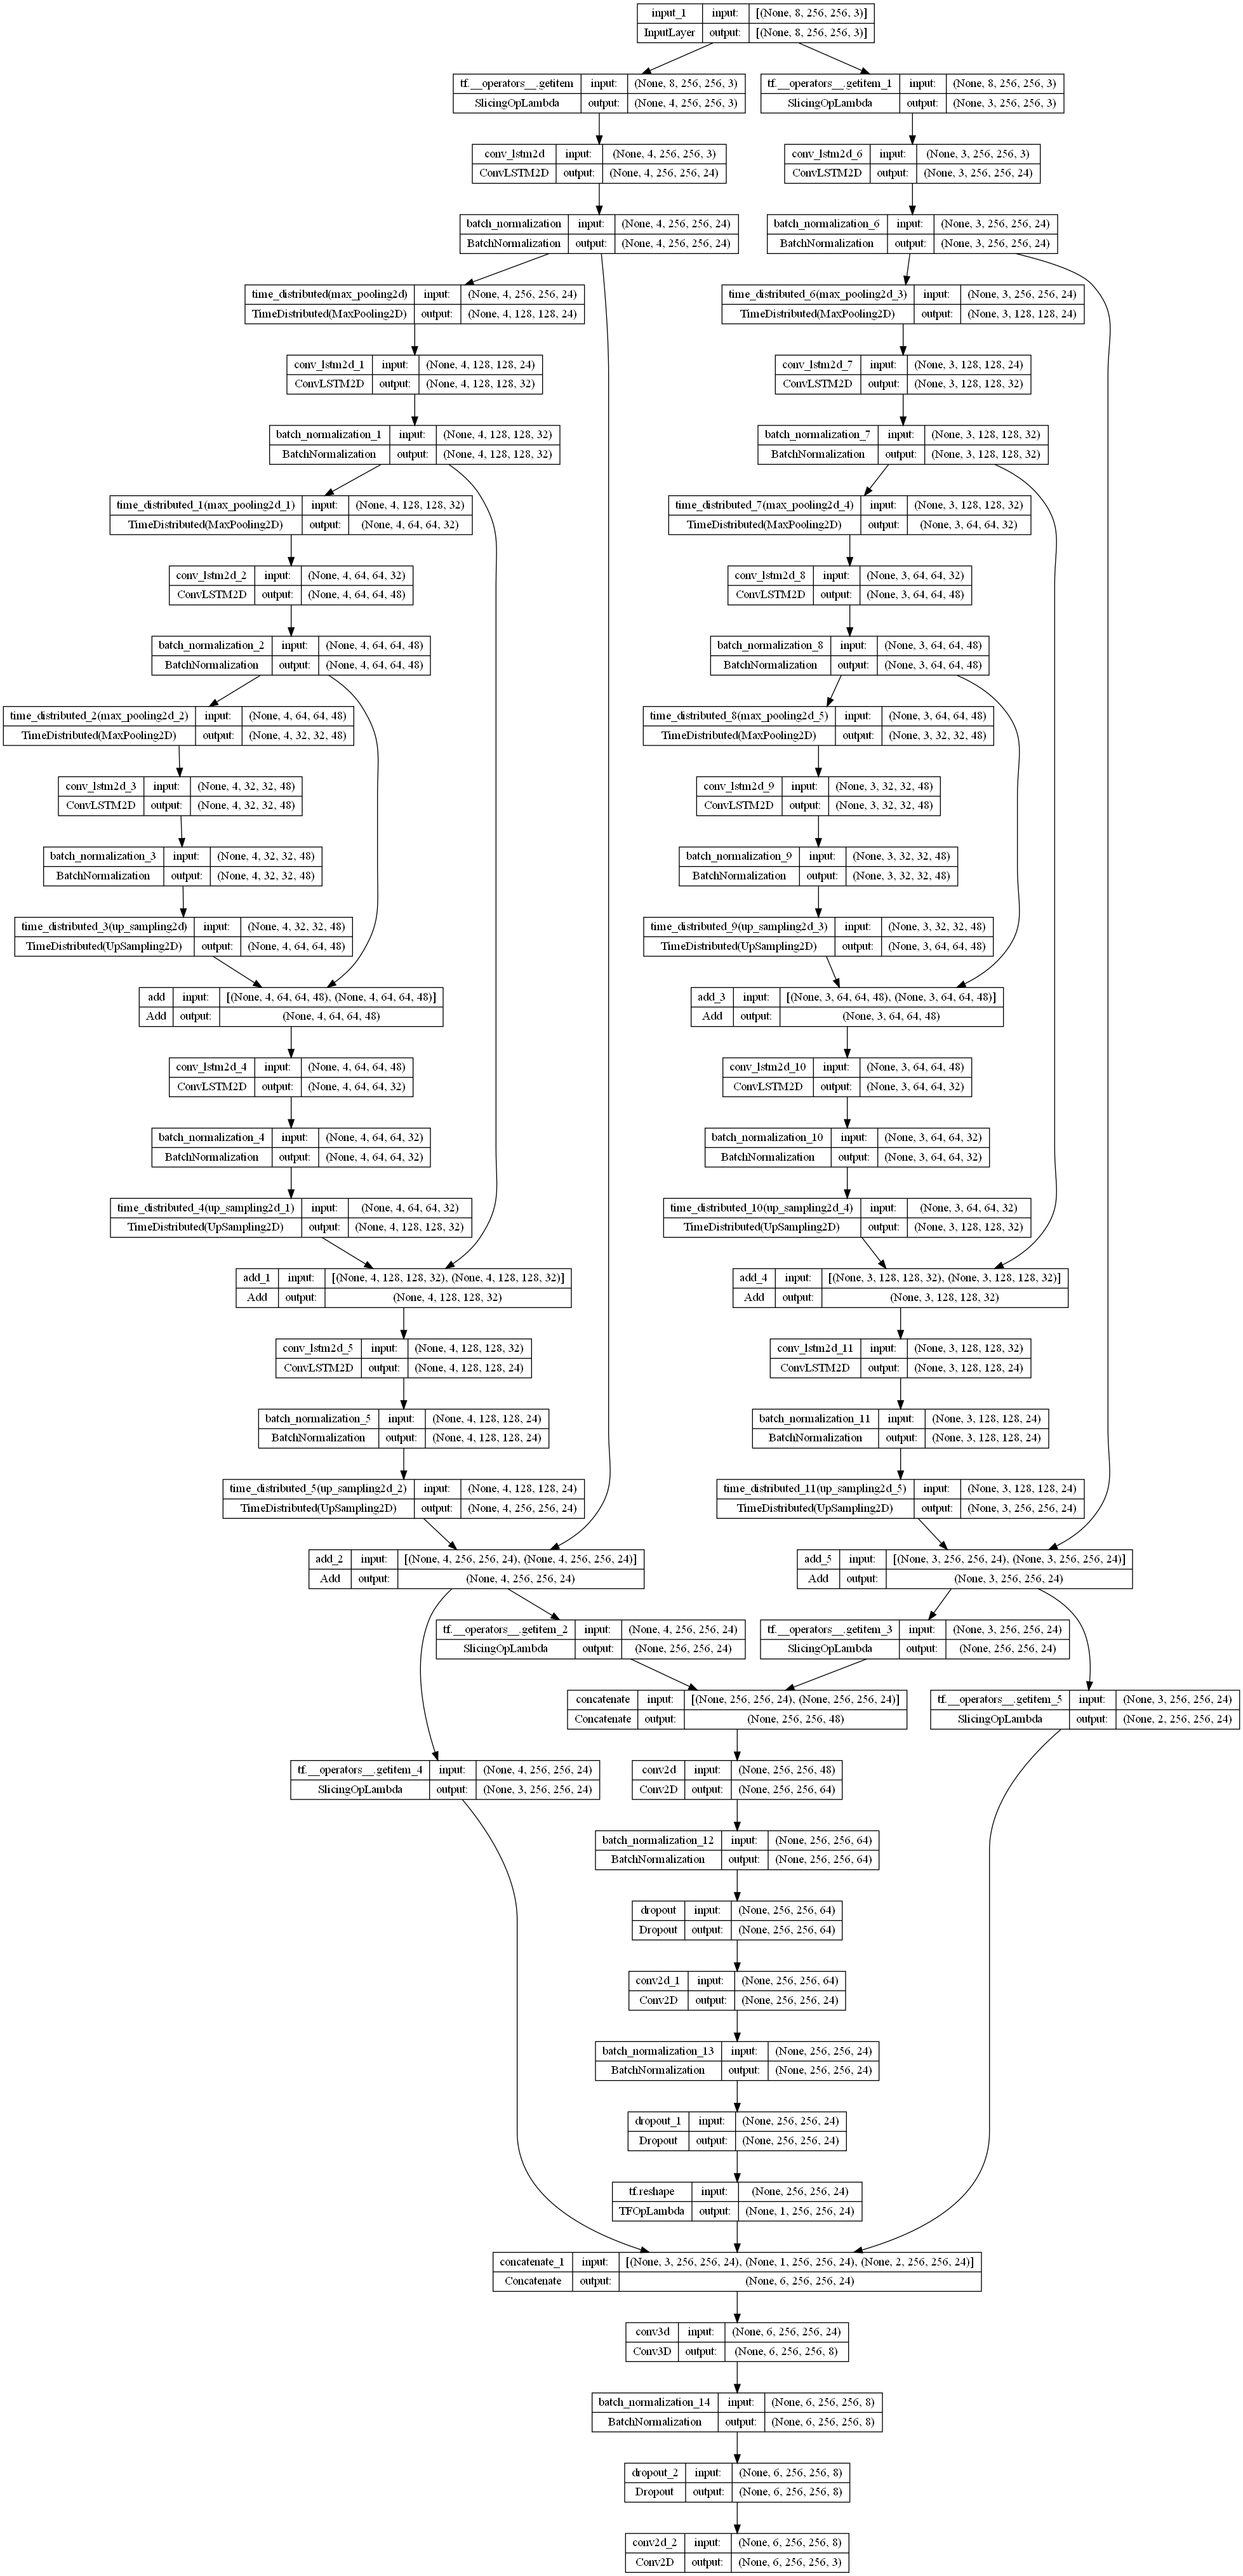

In [7]:
utils.plot_model(model, show_shapes=True, show_layer_names=True)

## Load Data and Calculation

In [8]:
def load_data_from_filelist(filelist):
    #num_file = len(filelist)

    Xs = []
    ys = []
    #for i in tqdm(range(num_file), position=0, leave=True):
    for y_filename in tqdm(filelist, position=0, leave=True):
        #y_filename = filelist[i]
        X_filename = y_filename.replace('_GroundTruth', '')

        Xs.append(np.load(X_filename))
        ys.append(np.load(y_filename))

    Xs = np.array(Xs).astype(np.float32)
    ys = np.array(ys).astype(np.float32)
    return Xs, ys

In [9]:
for fold_num in fold_nums:
    print(f'fold_{fold_num:02d}.txt')
    with open(f'fold_{fold_num:02d}.txt', 'r') as f:
        total_filenames = f.readlines()
    
    batch_size = int(len(total_filenames)/4)
    for batch in range(4):
        print([batch*batch_size, (batch+1)*batch_size])
        if batch < 3:
            filenames = total_filenames[batch*batch_size:(batch+1)*batch_size]
        else:
            filenames = total_filenames[batch*batch_size::]
        
        
        file_middles = []
        eff_filenames = []
        for i in range(len(filenames)):
            this_fn = filenames[i]
            this_fn = timestream_path + this_fn[2:-1].replace('/', '_') + '_GroundTruth.npy'
            this_middle = this_fn.split('\\')[-1].replace('_GroundTruth.npy', '')
            if not os.path.exists(output_path + this_middle + '.npy'):
                file_middles.append(this_middle)
                eff_filenames.append(this_fn)
        
        print(f'Read Data for fold {fold_num} batch {batch}')
        Xs, ys = load_data_from_filelist(eff_filenames)
        
        if Xs.shape[0] > 0:
            print(f'Calculation for fold {fold_num} batch {batch}')
            y_pred = model.predict(Xs)[:,3,...]
            print(f'Write dat for fold {fold_num} batch {batch}')
            for i, middle in tqdm(enumerate(file_middles)):
                this_filename = output_path + middle + '.npy'
                this_data = y_pred[i]
                np.save(this_filename, this_data)

fold_00.txt
[0, 513]
Read Data for fold 0 batch 0


0it [00:00, ?it/s]

[513, 1026]


Read Data for fold 0 batch 1


0it [00:00, ?it/s]

[1026, 1539]


Read Data for fold 0 batch 2


0it [00:00, ?it/s]

[1539, 2052]


Read Data for fold 0 batch 3


0it [00:00, ?it/s]

fold_01.txt
[0, 513]


Read Data for fold 1 batch 0


0it [00:00, ?it/s]

[513, 1026]


Read Data for fold 1 batch 1


0it [00:00, ?it/s]

[1026, 1539]


Read Data for fold 1 batch 2


0it [00:00, ?it/s]

[1539, 2052]


Read Data for fold 1 batch 3


0it [00:00, ?it/s]

fold_02.txt
[0, 513]


Read Data for fold 2 batch 0


0it [00:00, ?it/s]

[513, 1026]


Read Data for fold 2 batch 1


0it [00:00, ?it/s]

[1026, 1539]


Read Data for fold 2 batch 2


0it [00:00, ?it/s]

[1539, 2052]


Read Data for fold 2 batch 3


0it [00:00, ?it/s]

fold_03.txt
[0, 513]


Read Data for fold 3 batch 0


0it [00:00, ?it/s]

[513, 1026]


Read Data for fold 3 batch 1


0it [00:00, ?it/s]

[1026, 1539]


Read Data for fold 3 batch 2


0it [00:00, ?it/s]

[1539, 2052]


Read Data for fold 3 batch 3


0it [00:00, ?it/s]

fold_04.txt
[0, 513]


Read Data for fold 4 batch 0


0it [00:00, ?it/s]

[513, 1026]


Read Data for fold 4 batch 1


0it [00:00, ?it/s]

[1026, 1539]


Read Data for fold 4 batch 2


0it [00:00, ?it/s]

[1539, 2052]


Read Data for fold 4 batch 3


0it [00:00, ?it/s]

fold_05.txt
[0, 513]


Read Data for fold 5 batch 0


0it [00:00, ?it/s]

[513, 1026]


Read Data for fold 5 batch 1


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:19<00:00,  6.49it/s]


Calculation for fold 5 batch 1
17/17 [==============================] - 14s 532ms/step
Write dat for fold 5 batch 1


513it [00:12, 40.84it/s]


[1026, 1539]
Read Data for fold 5 batch 2


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:21<00:00,  6.29it/s]


Calculation for fold 5 batch 2
17/17 [==============================] - 9s 521ms/step
Write dat for fold 5 batch 2


513it [00:12, 40.11it/s]


[1539, 2052]
Read Data for fold 5 batch 3


100%|████████████████████████████████████████████████████████████████████████████████| 514/514 [01:22<00:00,  6.25it/s]


Calculation for fold 5 batch 3
17/17 [==============================] - 9s 524ms/step
Write dat for fold 5 batch 3


514it [00:13, 37.57it/s]


fold_06.txt
[0, 513]
Read Data for fold 6 batch 0


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:21<00:00,  6.28it/s]


Calculation for fold 6 batch 0
17/17 [==============================] - 9s 523ms/step
Write dat for fold 6 batch 0


513it [00:13, 38.00it/s]


[513, 1026]
Read Data for fold 6 batch 1


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:21<00:00,  6.29it/s]


Calculation for fold 6 batch 1
17/17 [==============================] - 9s 550ms/step
Write dat for fold 6 batch 1


513it [00:14, 34.24it/s]


[1026, 1539]
Read Data for fold 6 batch 2


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:22<00:00,  6.19it/s]


Calculation for fold 6 batch 2
17/17 [==============================] - 13s 740ms/step
Write dat for fold 6 batch 2


513it [00:15, 33.62it/s]


[1539, 2052]
Read Data for fold 6 batch 3


100%|████████████████████████████████████████████████████████████████████████████████| 514/514 [01:23<00:00,  6.17it/s]


Calculation for fold 6 batch 3
17/17 [==============================] - 15s 859ms/step
Write dat for fold 6 batch 3


514it [00:15, 32.29it/s]


fold_07.txt
[0, 513]
Read Data for fold 7 batch 0


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:24<00:00,  6.09it/s]


Calculation for fold 7 batch 0
17/17 [==============================] - 12s 680ms/step
Write dat for fold 7 batch 0


513it [00:16, 31.95it/s]


[513, 1026]
Read Data for fold 7 batch 1


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:26<00:00,  5.91it/s]


Calculation for fold 7 batch 1
17/17 [==============================] - 12s 680ms/step
Write dat for fold 7 batch 1


513it [00:16, 31.91it/s]


[1026, 1539]
Read Data for fold 7 batch 2


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:26<00:00,  5.95it/s]


Calculation for fold 7 batch 2
17/17 [==============================] - 12s 681ms/step
Write dat for fold 7 batch 2


513it [00:18, 28.46it/s]


[1539, 2052]
Read Data for fold 7 batch 3


100%|████████████████████████████████████████████████████████████████████████████████| 514/514 [01:27<00:00,  5.88it/s]


Calculation for fold 7 batch 3
17/17 [==============================] - 12s 689ms/step
Write dat for fold 7 batch 3


514it [00:20, 25.31it/s]


fold_08.txt
[0, 513]
Read Data for fold 8 batch 0


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:26<00:00,  5.91it/s]


Calculation for fold 8 batch 0
17/17 [==============================] - 12s 683ms/step
Write dat for fold 8 batch 0


513it [00:20, 25.45it/s]


[513, 1026]
Read Data for fold 8 batch 1


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:25<00:00,  6.02it/s]


Calculation for fold 8 batch 1
17/17 [==============================] - 12s 674ms/step
Write dat for fold 8 batch 1


513it [00:20, 25.04it/s]


[1026, 1539]
Read Data for fold 8 batch 2


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:25<00:00,  5.97it/s]


Calculation for fold 8 batch 2
17/17 [==============================] - 12s 687ms/step
Write dat for fold 8 batch 2


513it [00:19, 25.67it/s]


[1539, 2052]
Read Data for fold 8 batch 3


100%|████████████████████████████████████████████████████████████████████████████████| 514/514 [01:27<00:00,  5.88it/s]


Calculation for fold 8 batch 3
17/17 [==============================] - 12s 677ms/step
Write dat for fold 8 batch 3


514it [00:19, 26.47it/s]


fold_09.txt
[0, 513]
Read Data for fold 9 batch 0


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:21<00:00,  6.30it/s]


Calculation for fold 9 batch 0
17/17 [==============================] - 12s 680ms/step
Write dat for fold 9 batch 0


513it [00:21, 24.05it/s]


[513, 1026]
Read Data for fold 9 batch 1


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:20<00:00,  6.36it/s]


Calculation for fold 9 batch 1
17/17 [==============================] - 12s 684ms/step
Write dat for fold 9 batch 1


513it [00:24, 20.72it/s]


[1026, 1539]
Read Data for fold 9 batch 2


100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:24<00:00,  6.09it/s]


Calculation for fold 9 batch 2
17/17 [==============================] - 12s 678ms/step
Write dat for fold 9 batch 2


513it [00:20, 25.18it/s]


[1539, 2052]
Read Data for fold 9 batch 3


100%|████████████████████████████████████████████████████████████████████████████████| 514/514 [01:23<00:00,  6.15it/s]


Calculation for fold 9 batch 3
17/17 [==============================] - 12s 681ms/step
Write dat for fold 9 batch 3


514it [00:21, 23.49it/s]


## Varify

In [10]:
filenames = glob.glob(output_path+'*')

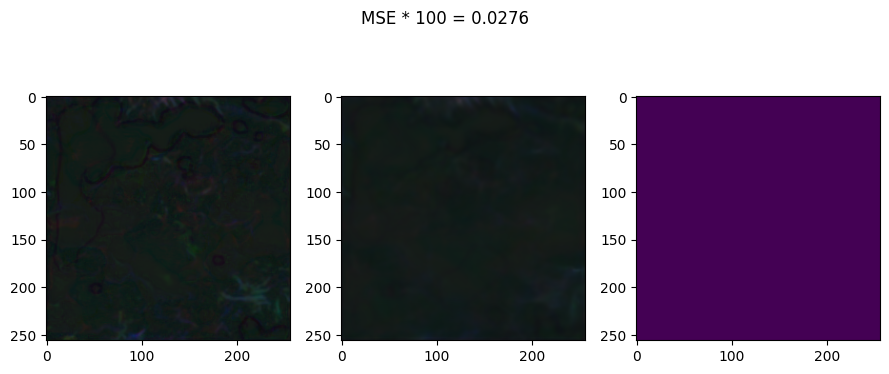

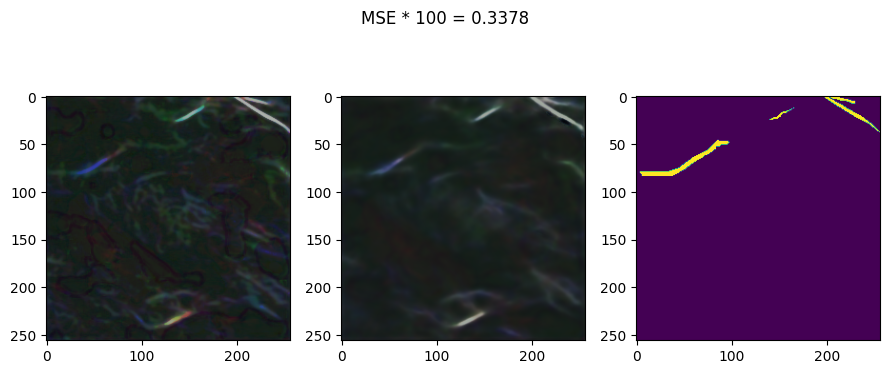

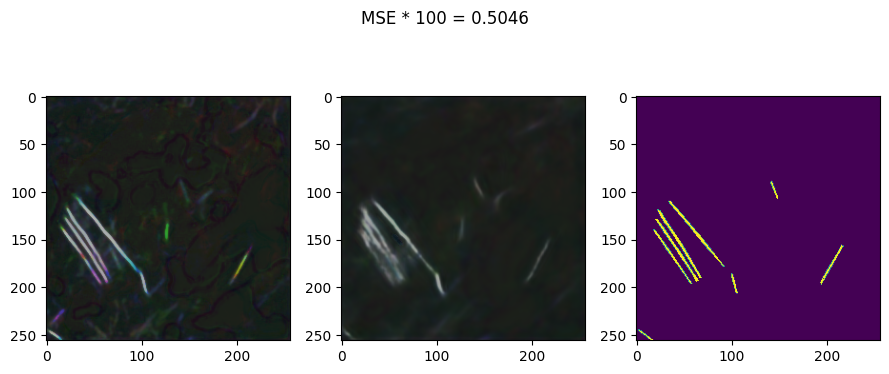

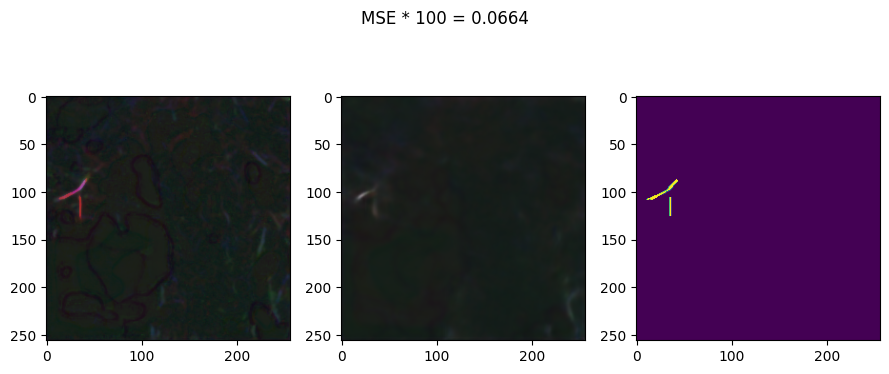

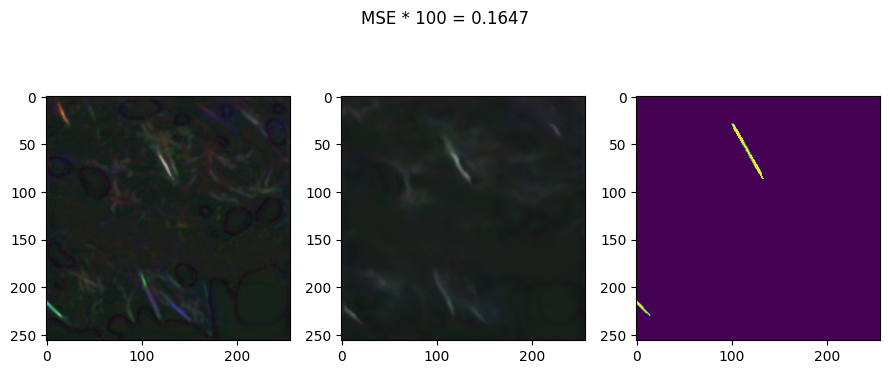

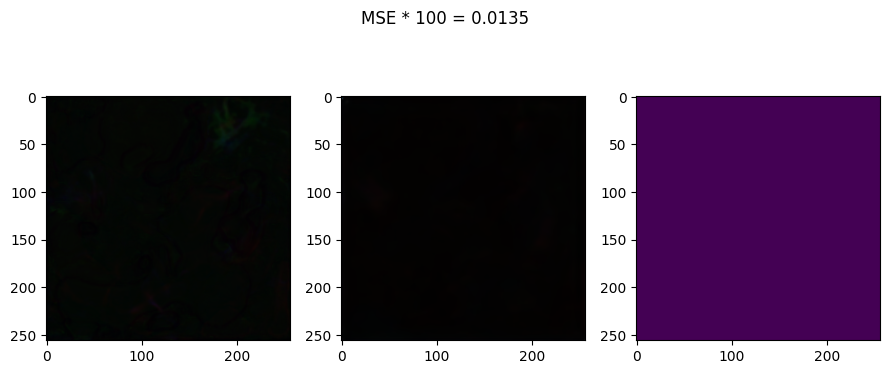

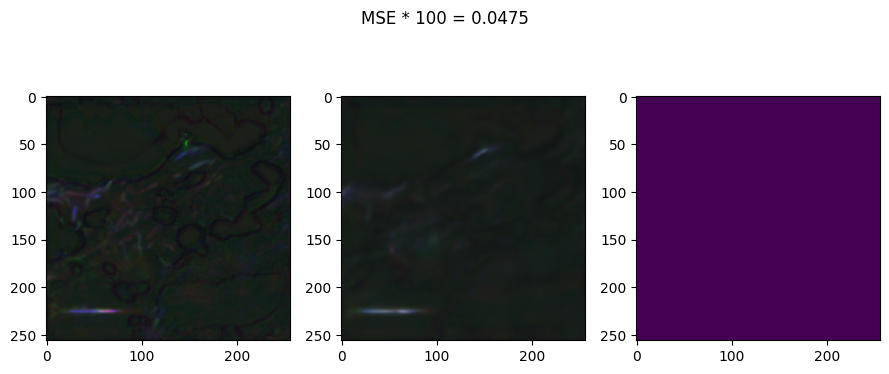

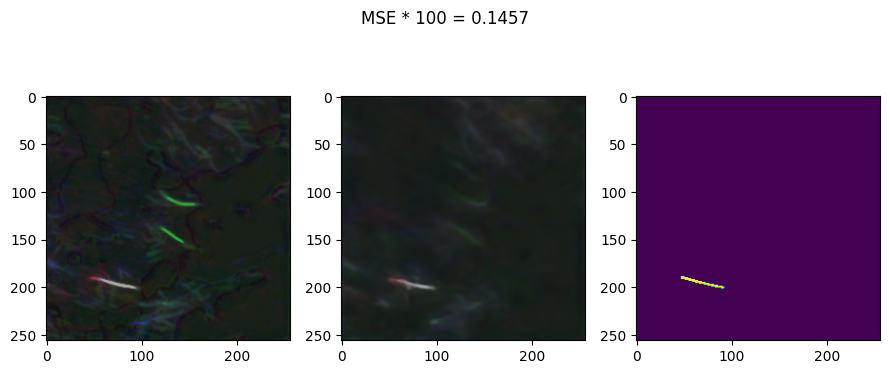

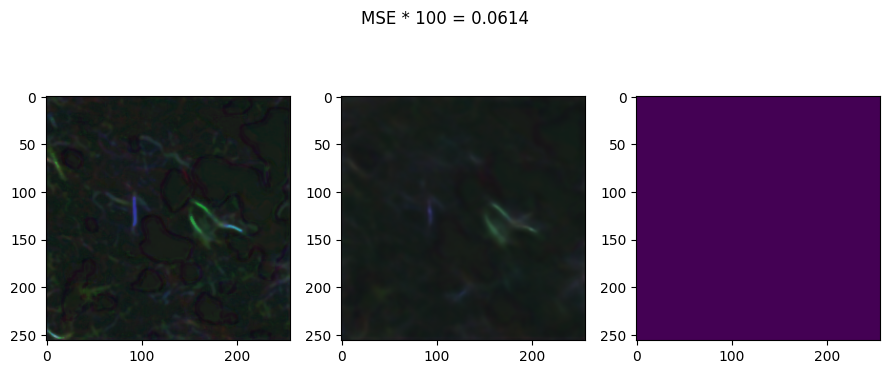

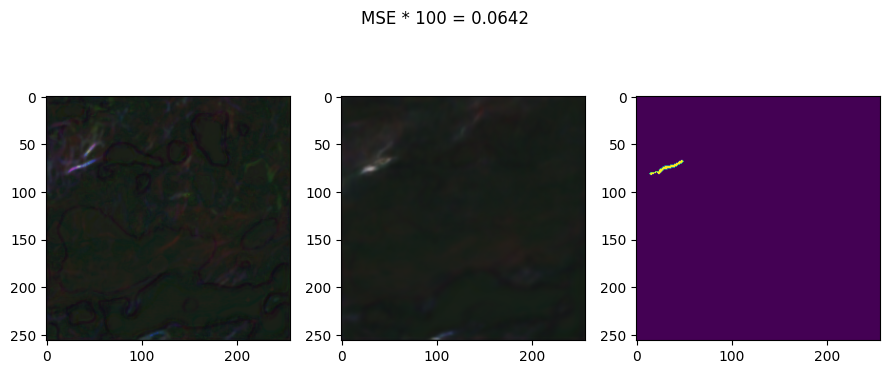

In [16]:
for _ in range(10):
    j = np.random.randint(len(filenames))
    S = filenames[j].split('\\')
    middle = S[-1][0:-4]
    
    timestream_data = np.load(timestream_path + middle + '.npy')
    interpolated_data = np.load(output_path + middle + '.npy')
    label_data = np.load(timestream_path + middle + '_GroundTruth.npy')
    
    fig, axes = plt.subplots(1, 3)
    axes[2].imshow(label_data)
    axes[1].imshow(interpolated_data)
    axes[0].imshow(timestream_data[4])
    fig.suptitle(f'MSE * 100 = {np.mean((timestream_data - interpolated_data)**2)*100:.4f}')
    fig.set_size_inches(9, 4)
    fig.tight_layout()
